# CMU Machine Learning with Large Datasets
## Homework 4 - Machine Learning at Scale

Note that we've included code that does data loading and preparation for you. You could take a brief look to learn about how to specify a schema when loading data, or just run them all and start from "Part B Begins" after adding your S3 bucket name to cmd 8.

Note that we will not be autograding this notebook because of the open-ended nature of it (although you will have to submit this notebook). To make grading easier and to learn about your thought process, throughout the notebook, we include questions you have to anwswer in your writeup. Whenver this happens, there is a ✰ symbol.

### 0. Start a Spark Session and Install Libraries

In [1]:
# You are highly recommended to select the "PySpark" kernel instead of python kernel,
# Otherwise you need to modify this cell to get pyspark working.

from pyspark.sql import *

sc = spark.sparkContext
print(f'num executors: {sc.getConf().get("spark.executor.instances")}')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1698512679246_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

num executors: 4

Throughout this assignment, you will be generating plots. `Matplotlib` and other useful Python libraries do not come pre-installed on the cluster. Therefore, you will have to ssh into your master node (think about why it should be the master) using your keypair created earlier and install `matplotlib`. You might have to do this later again for other libraries you use, e.g. `Pandas`.

Run the below cell to ensure you installation was successful. If an error occurs, you might want to double check your installation.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
'''
Note : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.
'''

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\nNote : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.\n'

### 1. Data Loading and Preparation

Earlier, we have extracted relevant features from and converted format of the full raw Million Song Dataset. We now want to load our converted dataset from the S3 Storage.

Note that although you can load all chunks of the dataset using `*`, we recommend you only load in a subset while developing so that processing takes shorter time when you are just verifying your ideas. Be sure to add your own S3 bucket name to cmd 8.

In [3]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

schema = StructType([StructField('song_hotttnesss', DoubleType(), True),
                       StructField('artist_familiarity', DoubleType(), True),
                       StructField('artist_hotttnesss', DoubleType(), True),
                       StructField('artist_id', StringType(), True),
                       StructField('artist_latitude', DoubleType(), True),
                       StructField('artist_location', StringType(), True),
                       StructField('artist_longitude', DoubleType(), True),
                       StructField('artist_name', StringType(), True),
                       StructField('title', StringType(), True),
                       StructField('danceability', DoubleType(), True),
                       StructField('duration', DoubleType(), True),
                       StructField('end_of_fade_in', DoubleType(), True),
                       StructField('energy', DoubleType(), True),
                       StructField('key', DoubleType(), True),
                       StructField('key_confidence', DoubleType(), True),
                       StructField('loudness', DoubleType(), True),
                       StructField('mode', DoubleType(), True),
                       StructField('mode_confidence', DoubleType(), True),
                       StructField('start_of_fade_out', DoubleType(), True),
                       StructField('tempo', DoubleType(), True),
                       StructField('time_signature', DoubleType(), True),
                       StructField('time_signature_confidence', DoubleType(), True),
                       StructField('artist_terms', StringType(), True),
                       StructField('artist_terms_freq', StringType(), True),
                       StructField('artist_terms_weight', StringType(), True),
                       StructField('year', DoubleType(), True)]
                   )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#--------------------------------------------------------------------
#Set to False after writing your code and run end-to-end on full data
#--------------------------------------------------------------------
load_subset = False
#----------------------------
#Add your s3 bucket name below:
#----------------------------
s3_bucket_name = 'yanhw4tempbucket'

if load_subset:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/A_1.csv")
else:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/*.csv")

print('loaded {} records'.format(df.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loaded 581965 records

Inspect the `df` we just created by running the below cell:

In [5]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string

<div align="center">
    <h1>------------------- Part B Begins ------------------- </h1>
</div>

### 2. Exploratory Data Analysis

Now we have our data mostly ready. It's a good time to take some deeper look to better understand what we are dealing with here.

First, show summary statistics of the features using `.summary()`. Hint: because we have many features, the output might be too long for a single line. The simplest way to resolve this mess is to copy paste the output to some editor (e.g. vscode) and check the result. Another way is you could select only a few features to print at a time so that things could fit into one line.

In [6]:
# YOUR CODE HERE
summary = df.summary()
summary.show()
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+------------------+-------------------+------------------+---------------+------------------+----------------+-----------+--------------------+------------+------------------+------------------+------+-----------------+-------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+-------------------------+--------------------+-----------------+--------------------+------------------+
|summary|    song_hotttnesss|artist_familiarity|  artist_hotttnesss|         artist_id|artist_latitude|   artist_location|artist_longitude|artist_name|               title|danceability|          duration|    end_of_fade_in|energy|              key|     key_confidence|         loudness|               mode|   mode_confidence| start_of_fade_out|             tempo|    time_signature|time_signature_confidence|        artist_terms|artist_terms_freq| artist_terms_weight|              year|
+-------+---------------

Now looking at the statistics, `danceability` and `energy` appear strange. ✰2.3(a) Explain why these features seem problematic in your writeup.

Now we would like to make some histogram plots to inspect the distribution of feature values. 

✰2.3(b) Plot histograms for `'song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'duration', 'tempo', 'year'`. 

Note that one of these features may appear weird. 

✰2.3(c) Explain what is weird about `year`'s distribution and what might cause this. Describe how you could filter `year` to make its histogram look more balanced. Hint: Choose a threshold and filter the `year` values.

✰2.3(d) Do it and include the new plot of this feature into your writeup.

Note: you may want to use the spark magic commands `%matplot plt` to show the plot.

In [7]:
# YOUR CODE HERE
data = df.select('song_hotttnesss').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 5))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram for song_hotttnesss')
plt.xlabel('song_hotttnesss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

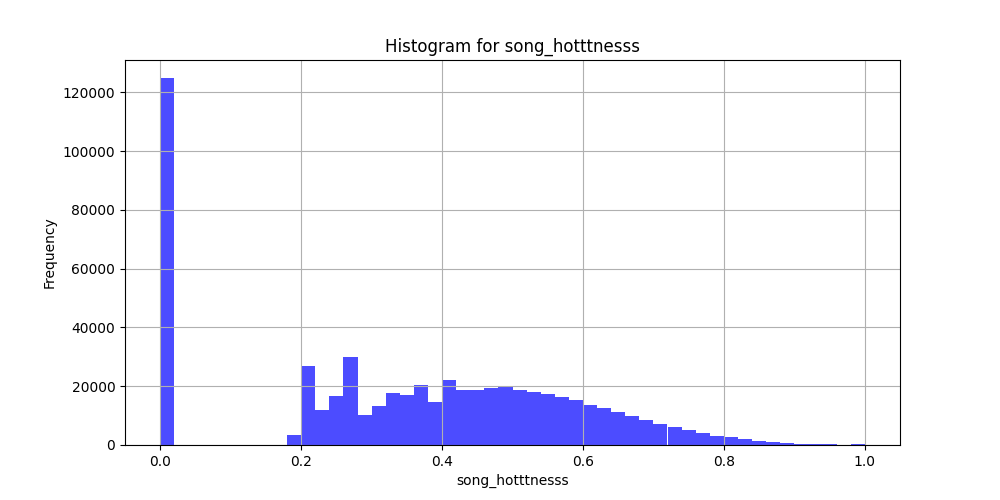

In [8]:
%matplot plt

In [9]:
data = df.select('artist_familiarity').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 5))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram for artist_familiarity')
plt.xlabel('artist_familiarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

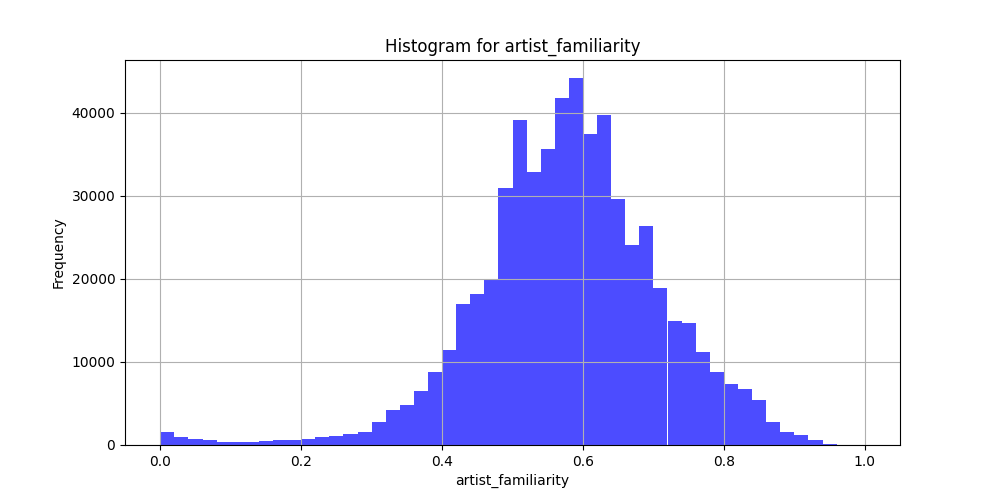

In [10]:
%matplot plt

In [11]:
data = df.select('artist_hotttnesss').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 5))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram for artist_hotttnesss')
plt.xlabel('artist_hotttnesss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

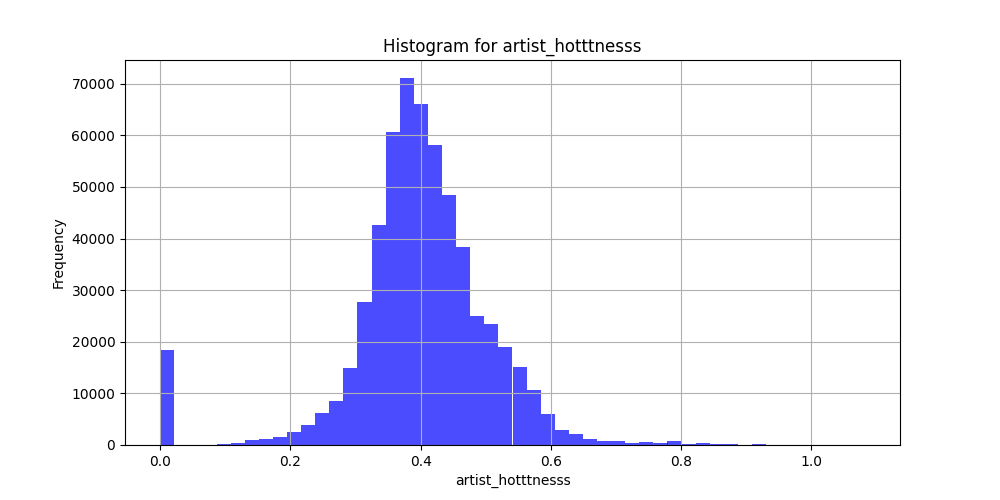

In [12]:
%matplot plt

In [13]:
data = df.select('duration').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 5))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram for duration')
plt.xlabel('duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

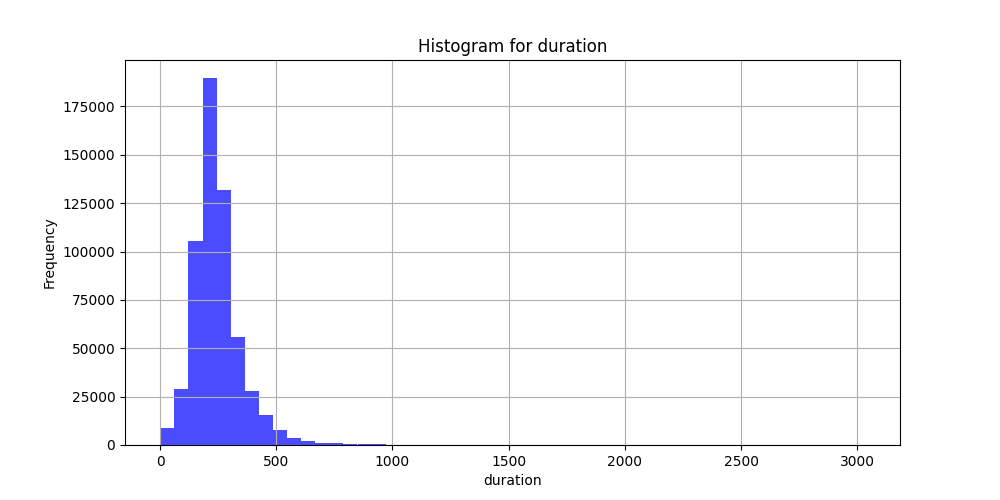

In [14]:
%matplot plt

In [15]:
data = df.select('tempo').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 5))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram for tempo')
plt.xlabel('tempo')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

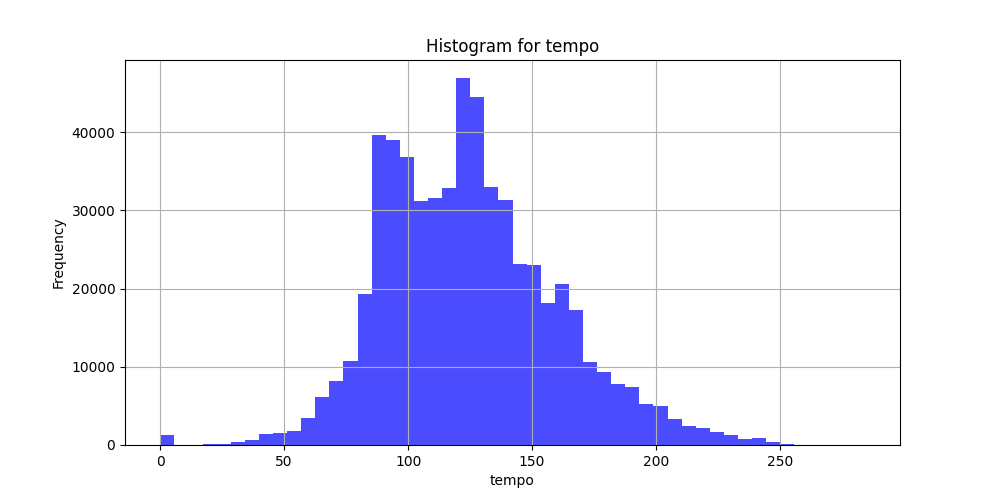

In [16]:
%matplot plt

In [17]:
data = df.select('year').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 5))
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram for year')
plt.xlabel('year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

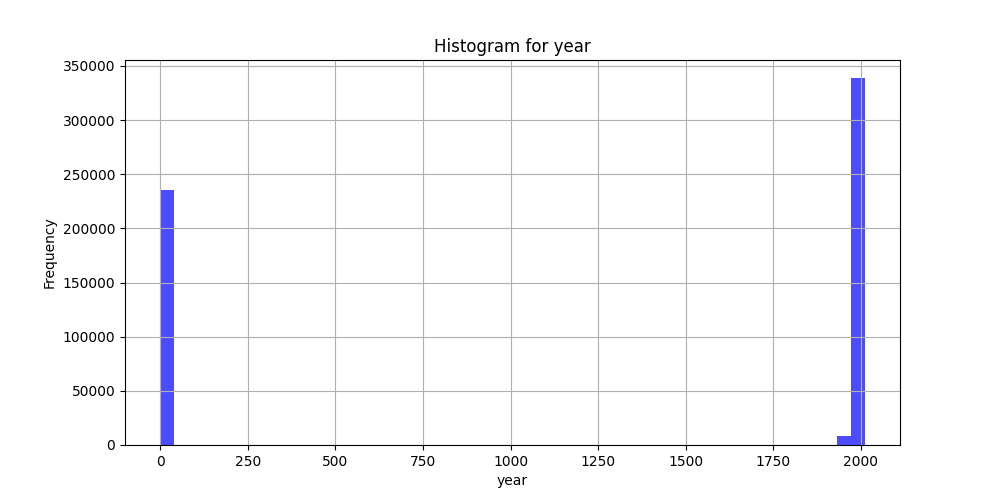

In [18]:
%matplot plt

In [19]:
df_filtered = df.filter(df.year >= 1950)
# Now, plot the histogram for the filtered 'year' feature
years = df_filtered.select('year').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 5))
plt.hist(years, bins=50, color='green', alpha=0.7)
plt.title('Histogram for Filtered Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

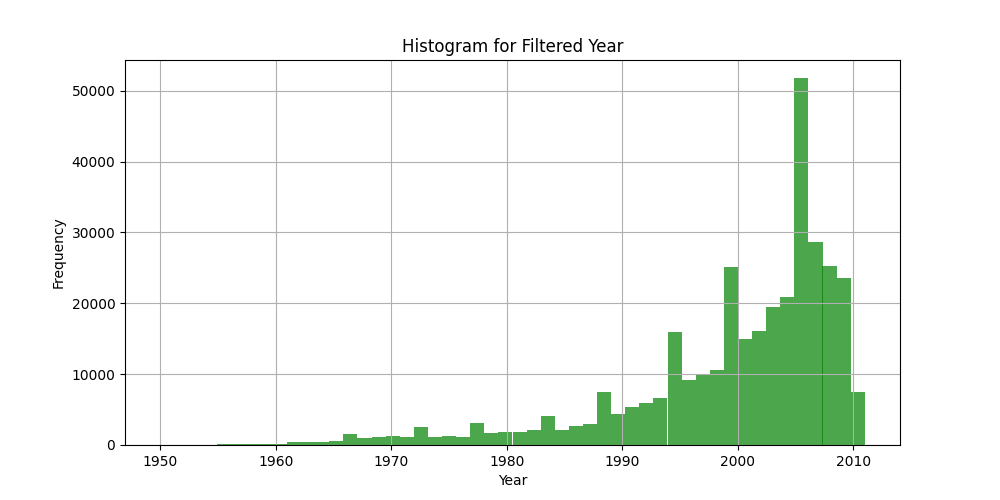

In [20]:
%matplot plt

Some scatter pair plots would also be interesting to see the correlation between features. ✰2.3(e) Include the plots of the following pairs of features and describe your findings (e.g. what patterns you observe) in your writeup.
- `song_hotttnesss` against `artist_familiarity`
- `artist_latitude` against `artist_longitude`
- `song_hotttnesss` against `year`

Plotting all data points might explode matplotlib. Think about what simple technique you could use to visualize large datasets while retaining data distribution. ✰2.3(f) In your writeup, briefly describe what you did.

In [21]:
sample_fraction = 0.1  

data1_sample = df.sample(False, sample_fraction).select('song_hotttnesss', 'artist_familiarity').rdd.collect()
data2_sample = df.sample(False, sample_fraction).select('artist_latitude', 'artist_longitude').rdd.collect()
data3_sample = df.sample(False, sample_fraction).select('song_hotttnesss', 'year').rdd.collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# YOUR CODE HERE
x1, y1 = zip(*data1_sample)
plt.figure(figsize=(10,6))
plt.scatter(x1, y1, alpha=0.5)
plt.title("song_hotttnesss vs artist_familiarity")
plt.xlabel("song_hotttnesss")
plt.ylabel("artist_familiarity")
plt.show()
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

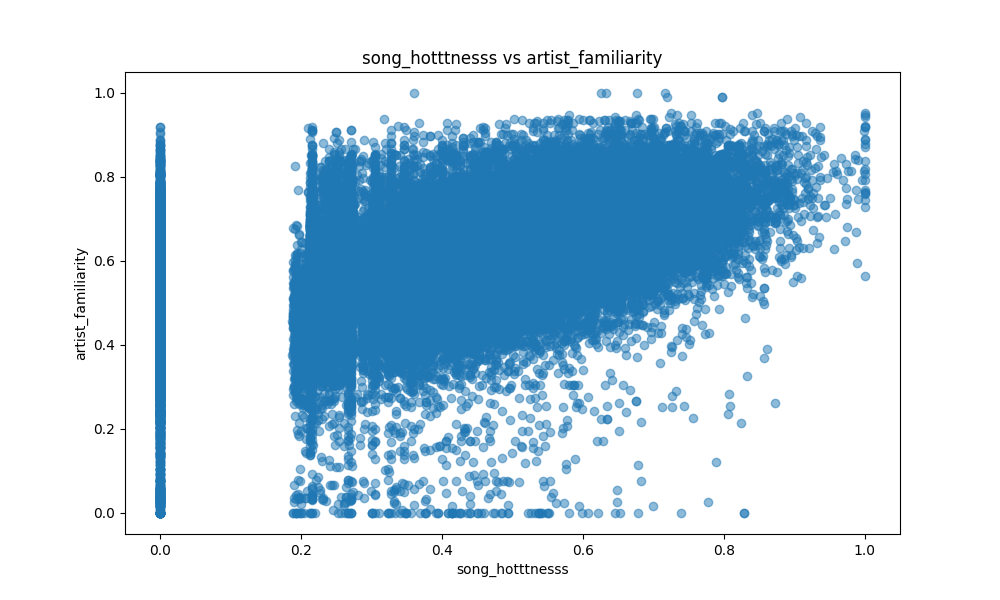

In [23]:
%matplot plt

In [24]:
x2, y2 = zip(*data2_sample)
plt.figure(figsize=(10,6))
plt.scatter(x2, y2, alpha=0.5)
plt.title("artist_latitude vs artist_longitude")
plt.xlabel("artist_latitude")
plt.ylabel("artist_longitude")
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

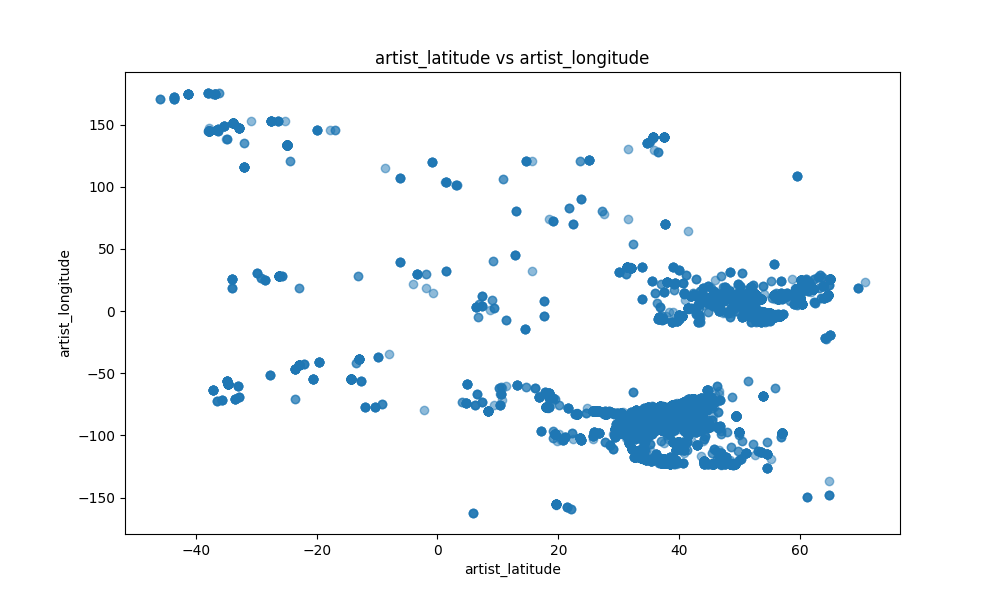

In [25]:
%matplot plt

In [26]:
# Plotting song_hotttnesss against year
x3, y3 = zip(*data3_sample)
plt.figure(figsize=(10,6))
plt.scatter(x3, y3, alpha=0.5)
plt.title("song_hotttnesss vs year")
plt.xlabel("song_hotttnesss")
plt.ylabel("year")
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

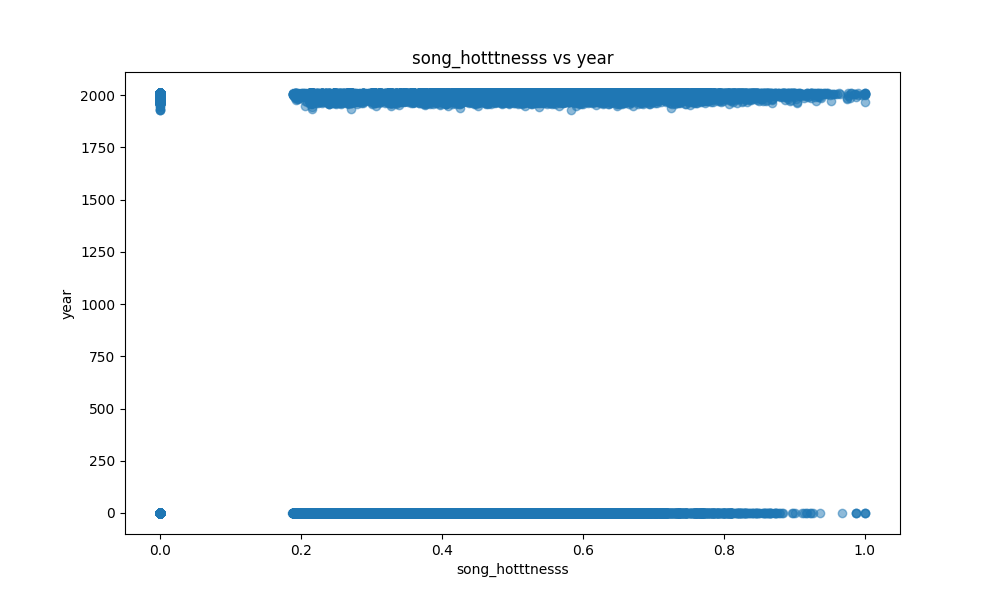

In [27]:
%matplot plt

### 3. Data Cleaning

From 2, you should have had a basic understanding of the dataset. In this cleaning step, we are dropping `energy` and `danceability` features. 

✰2.4(a) In your writeup, justify why we are doing this.

In [28]:
# YOUR CODE HERE
df_cleaned = df.drop('energy', 'danceability')
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For simplicity, we are dropping `year` values that are less or equal to 1920. Print out the number of samples before and after dropping these rows. 

✰2.4(b) In your writeup, compare these two numbers and explain the advantages and potential problem of doing this step. What other techniques could you use to potentially do better?

In [29]:
# YOUR CODE HERE
initial_count = df_cleaned.count()

df_cleaned_year = df_cleaned.filter(df.year > 1920)

after_count = df_cleaned_year.count()

print(f"Initial number of samples: {initial_count}")
print(f"Number of samples after dropping: {after_count}")
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Initial number of samples: 581965
Number of samples after dropping: 346444

Now, let's do an NaN check to see if there are other problematic features. Print the number of entries that contain NaN for each feature. 

Hint: use pyspark sql `count(when(isnull(...)))` to count total Null entries for a feature. Replace `isnull` with `isnan` to count nan entries.

In [30]:
# count na
from pyspark.sql.functions import isnan, when, count, isnull, col

# YOUR CODE HERE
nan_counts = {}
for column in df_cleaned_year.columns:
    nan_count = df_cleaned_year.select(count(when(isnan(col(column)), column))).collect()[0][0]
    nan_counts[column] = nan_count

# Print out the results
for column, nan_count in nan_counts.items():
    print(f"{column}: {nan_count} NaN entries")

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

song_hotttnesss: 0 NaN entries
artist_familiarity: 1 NaN entries
artist_hotttnesss: 0 NaN entries
artist_id: 0 NaN entries
artist_latitude: 219399 NaN entries
artist_location: 0 NaN entries
artist_longitude: 219399 NaN entries
artist_name: 0 NaN entries
title: 1 NaN entries
duration: 0 NaN entries
end_of_fade_in: 0 NaN entries
key: 0 NaN entries
key_confidence: 0 NaN entries
loudness: 0 NaN entries
mode: 0 NaN entries
mode_confidence: 0 NaN entries
start_of_fade_out: 0 NaN entries
tempo: 0 NaN entries
time_signature: 0 NaN entries
time_signature_confidence: 0 NaN entries
artist_terms: 0 NaN entries
artist_terms_freq: 0 NaN entries
artist_terms_weight: 0 NaN entries
year: 0 NaN entries

We should see two features that contain (a lot of) `nan` in them. ✰2.4(c) Which two are they? 

For simplicity, we are dropping all records with `nan` in these two features. Note that this drops a significant proportion of our dataset. Since we have a lot of data to fit some rather simple models, this might be ok. 

However, do note that this is not usually desirable in the real-word because we always want to retain as much data as possible, especially when training larger, more complex models. ✰2.4(d) In your writeup, explain what possible techniques could you employ to deal with this situation. Discuss the pros and cons of your proposed solution.

In [31]:
# YOUR CODE HERE
df_no_nan = df_cleaned_year.dropna(subset=['artist_latitude', 'artist_longitude'])
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

✰2.4(e) Finally in your writeup, report the percentage of records that survived our very aggressive data cleaning.

In [32]:
# counting code
final_count = df_no_nan.count()
percentage_survived = (final_count / initial_count) * 100

print(f"Percentage of records that survived cleaning: {percentage_survived:.2f}%")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of records that survived cleaning: 21.83%

### 4. Baseline

Now we have the data (almost) ready to do some preliminary modeling! 

We will be treating this problem as a classification problem, i.e. given some features, predict whether a song will be popular. We define a song to be popular if its `song_hotttnesss` value is above average. 

✰2.5(a) Explain in your writeup why treating this as a classification problem (instead of a regression problem) might be a sensible choice. 

Then, assign labels to the dataset with the above definition of "popularity".

In [33]:
from pyspark.sql.functions import col, expr, when, avg

# assign labels
# YOUR CODE HERE
average_hotttnesss = df_no_nan.agg(avg(col("song_hotttnesss"))).collect()[0][0]

df_labeled = df_no_nan.withColumn("label", when(col("song_hotttnesss") > average_hotttnesss, 1).otherwise(0))
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's take a look at how balanced the two classes are. ✰2.5(b) Report what percentage of songs are assigned the "popular" label.

In [34]:
# YOUR CODE HERE
total_songs = df_labeled.count()

# Count the number of popular songs (where label = 1)
popular_songs = df_labeled.filter(col("label") == 1).count()

# Calculate the percentage of songs labeled as "popular"
percentage_popular = (popular_songs / total_songs) * 100

print(f"Percentage of songs labeled as 'popular': {percentage_popular:.2f}%")
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of songs labeled as 'popular': 55.99%

As how we've been dealing with the `year` feature in earlier assignments, we will shift the feature so that it starts from 0.

✰2.5(c) Explain why we want to do this.

In [35]:
# shift years
# YOUR CODE HERE
from pyspark.sql.functions import min

min_year = df_labeled.select(min("year")).first()[0]
df_shifted_year = df_labeled.withColumn("year", col("year") - min_year)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Finally, let's concatenate all features (using VectorAssembler) into a feature vector and scale it. 

✰2.5(d) Explain what scaling means and why we want to perform scaling before the learning step.

Note: we will only be using the numeric features for now. Excluding `song_hotttnesss` and the two features we dropped in the data cleaning step, there should be 19-3=16 of them.

In [36]:
# assembling vector
feature_cols = [
    'artist_familiarity', 'artist_hotttnesss', 'artist_latitude', 'artist_longitude',
    'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode',
    'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'year'
]

from pyspark.ml.feature import VectorAssembler

# YOUR CODE HERE
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_shifted_year)  
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# scaling

from pyspark.ml.feature import StandardScaler

# YOUR CODE HERE
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's verify the resulting feature vector is of expected length 16.

In [38]:
# change your variable/column names accordingly
l = df_scaled.select('scaled_features').take(1)[0].scaled_features
print('vector len:',len(l))
assert len(l) == 16

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 16

Now, we are really ready to fit some models. 

First, do a train-test split on the dataset, with test ratio 0.2 and seed 10605.

In [39]:
# YOUR CODE HERE
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=10605)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We have to select a metric to evaluate our models on. For classification, potential choices include accuracy and AUC. ✰2.5(e) In your writeup, explain the difference between these two metrics and when AUC might be more useful than accuracy.

We will be going with AUC here. Instantiate an AUC Evaluator in the following cell.

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# YOUR CODE HERE
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We will be fitting two models, logistic regression, and random forest, in the mandatory part. You have the chance go with fancier models in the last section to achieve higher accuracy to earn additional points.

Train a LR and a RF model with default hyperparameters. ✰2.5(f) Calculate the train and test AUC of both models and report them in your writeup.

In [41]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

# YOUR CODE HERE
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction")

lr_model = lr.fit(train_data)

lr_train_predictions_baseline = lr_model.transform(train_data)
lr_test_predictions_baseline = lr_model.transform(test_data)

lr_train_auc = evaluator.evaluate(lr_train_predictions_baseline)
lr_test_auc = evaluator.evaluate(lr_test_predictions_baseline)

print(f"Logistic Regression - Train AUC: {lr_train_auc}")
print(f"Logistic Regression - Test AUC: {lr_test_auc}")
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression - Train AUC: 0.7545358768092437
Logistic Regression - Test AUC: 0.7552175140382875

In [42]:
# Random Forest

from pyspark.ml.classification import RandomForestClassifier

# YOUR CODE HERE
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction")

rf_model = rf.fit(train_data)

rf_train_predictions_baseline = rf_model.transform(train_data)
rf_test_predictions_baseline = rf_model.transform(test_data)

rf_train_auc = evaluator.evaluate(rf_train_predictions_baseline)
rf_test_auc = evaluator.evaluate(rf_test_predictions_baseline)

print(f"Random Forest - Train AUC: {rf_train_auc}")
print(f"Random Forest - Test AUC: {rf_test_auc}")
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest - Train AUC: 0.7636757605336973
Random Forest - Test AUC: 0.7634130041506864

### 5. Featurization: Bag-of-Words and TF-IDF

In our list of features, we have two features that contain text data, namely `title` and `artist_terms`. In the entity resolution task of HW1, we've seen how TF-IDF could help us featurize textual data. Let's do that here as well. [Bag-of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) is yet another technique (arguably simpler than TF-IDF) to featurize text features.


To get yourself familiar with both in Spark, let's treat titles and artist terms as mini documents and compute TF-IDF for `title` and BoW for `artist_terms`.

In [43]:
# tf-idf on title

from pyspark.ml.feature import Tokenizer, HashingTF, IDF

TF_IDF_NUM_FEATS = 5 # HashingTF(..., numFeatures=TF_IDF_NUM_FEATS)

# YOUR CODE HERE
tokenizer_title = Tokenizer(inputCol="title", outputCol="title_tokens")
tokenized_title = tokenizer_title.transform(df_scaled)

hashingTF_title = HashingTF(inputCol="title_tokens", outputCol="title_tf", numFeatures=TF_IDF_NUM_FEATS)
tf_title = hashingTF_title.transform(tokenized_title)

idf_title = IDF(inputCol="title_tf", outputCol="title_tfidf").fit(tf_title)
tfidf_title = idf_title.transform(tf_title)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the resulting TF-IDF feature is indeed a vector of length `TF_IDF_NUM_FEATS`.

In [44]:
# change variable/column name to yours
from pyspark.ml.linalg import SparseVector

col_name = 'title_tfidf'
head = tfidf_title.select(col_name).head() 
print(head)
assert type(head[col_name]) == SparseVector
assert len(head[col_name]) == TF_IDF_NUM_FEATS

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(title_tfidf=SparseVector(5, {1: 0.8022, 2: 0.6637, 3: 0.696}))

Recall that `artist_terms` should be of type string array but we have not yet interpreted from a string literal. Let's do that now. 

Hint: start by defining a UDF to convert a single string literal to type `T.ArrayType(T.StringType())`.

In [45]:
from pyspark.sql.functions import udf
import pyspark.sql.types as T
import ast

# YOUR CODE HERE
def string_to_array(s):
    try:
        return ast.literal_eval(s)
    except:
        return []

string_to_array_udf = udf(string_to_array, T.ArrayType(T.StringType()))

df_tags_arr = tfidf_title.withColumn('artist_terms_arr', string_to_array_udf(tfidf_title['artist_terms']))

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's do a quick check things indeed worked out.

In [46]:
# change to your variable/column names
col_name = 'artist_terms_arr'
head = df_tags_arr.select(col_name).head()
print(head)
assert type(head[col_name]) == list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_arr=['hardcore punk', 'heavy metal', 'hardcore metal', 'thrash core', 'hard rock', 'death core', 'crossover thrash', 'metalcore', 'nu metal', 'rock', 'melodic black metal', 'thrash metal', 'hardcore', 'melodic death metal', 'power metal', 'screamo', 'progressive metal', 'black metal', 'punk', 'emo', 'death metal', 'hip hop', 'rap', 'alternative rock', 'punk metal', 'united states', 'singer-songwriter', 'metal', 'american', 'new york hardcore', 'alternative', 'germany', 'indie', 'christian', '00s', 'heavy', 'new york', 'crossover', 'new york city', 'old school hardcore', 'drums', 'trash metal', 'beat down'])

Now perform BoW on the array feature you just created.

✰2.6(a) In your writeup, explain what the `vocabSize` hyperparameter means in the context of Bag-of-Words. Remember you can tune this later in the last section.

In [47]:
# BoW on artist_terms

from pyspark.ml.feature import CountVectorizer

BOW_VOCAB_SIZE = 10 
BOW_MIN_DF = 2
# CountVectorizer(..., vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)

# YOUR CODE HERE
countVectorizer = CountVectorizer(inputCol="artist_terms_arr", outputCol="artist_terms_bow", vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)
model = countVectorizer.fit(df_tags_arr)
df_final = model.transform(df_tags_arr)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the result of BoW is indeed a vector of length `BOW_VOCAB_SIZE`.

In [48]:
# change variable/column name to yours
from pyspark.ml.linalg import SparseVector

col_name = 'artist_terms_bow'
head = df_final.select(col_name).head() 
print(head)
assert type(head[col_name]) == SparseVector
assert len(head[col_name]) == BOW_VOCAB_SIZE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_bow=SparseVector(10, {0: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 7: 1.0}))

✰2.6(b) Other than featurizing texts, what other feature engineering would you do on the dataset? Briefly describe one in your writeup.

Now with the new feature columns ready, let's assemble and scale our features once again as we did to prepare for training. 

This time, we should have 16+2=18 features with the two being TF-IDF and BoW features we just created. The total length of the resulting feature vector should be 31. ✰2.6(c) Explain where this number (31) comes from in your writeup.

In [49]:
# assembling vector
feature_cols = [
    'artist_familiarity', 'artist_hotttnesss', 'artist_latitude', 'artist_longitude',
    'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode',
    'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'year'
]
feature_cols += ['title_tfidf', 'artist_terms_bow']

# YOUR CODE HERE
assembler = VectorAssembler(inputCols=feature_cols, outputCol='final_features')
df_assembled = assembler.transform(df_final)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
df_assembled.select('final_features').head(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(final_features=DenseVector([0.6849, 0.3704, 40.7038, -73.8317, 187.4281, 0.218, 2.0, 0.974, -4.694, 1.0, 0.643, 184.134, 93.378, 4.0, 0.298, 85.0, 0.0, 0.8022, 0.6637, 0.696, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0])), Row(final_features=DenseVector([0.4811, 0.3374, 47.6036, -122.3294, 235.1277, 0.293, 4.0, 0.787, -7.707, 0.0, 0.869, 227.213, 125.355, 4.0, 0.065, 85.0, 0.0, 0.0, 0.6637, 2.0879, 0.847, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0])), Row(final_features=DenseVector([0.7611, 0.4623, 50.5144, 4.4251, 250.7228, 0.0, 8.0, 0.608, -22.078, 1.0, 0.58, 247.705, 40.414, 1.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.696, 0.847, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0])), Row(final_features=DenseVector([0.5898, 0.3989, 40.8572, -73.8568, 152.7375, 0.212, 3.0, 0.381, -11.202, 1.0, 0.576, 145.833, 92.585, 3.0, 0.798, 36.0, 0.7749, 0.0, 0.0, 1.3919, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0])), Row(final_features=DenseVector([0.7367, 0.5262, 34.0535, -11

In [51]:
from pyspark.ml.linalg import DenseVector, VectorUDT

to_dense_udf = udf(lambda v: DenseVector(v.toArray()) if v is not None else None, VectorUDT())

df_assembled = df_assembled.withColumn('final_features', to_dense_udf('final_features'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
df_assembled.select('final_features').head(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(final_features=DenseVector([0.6849, 0.3704, 40.7038, -73.8317, 187.4281, 0.218, 2.0, 0.974, -4.694, 1.0, 0.643, 184.134, 93.378, 4.0, 0.298, 85.0, 0.0, 0.8022, 0.6637, 0.696, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0])), Row(final_features=DenseVector([0.4811, 0.3374, 47.6036, -122.3294, 235.1277, 0.293, 4.0, 0.787, -7.707, 0.0, 0.869, 227.213, 125.355, 4.0, 0.065, 85.0, 0.0, 0.0, 0.6637, 2.0879, 0.847, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0])), Row(final_features=DenseVector([0.7611, 0.4623, 50.5144, 4.4251, 250.7228, 0.0, 8.0, 0.608, -22.078, 1.0, 0.58, 247.705, 40.414, 1.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.696, 0.847, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0])), Row(final_features=DenseVector([0.5898, 0.3989, 40.8572, -73.8568, 152.7375, 0.212, 3.0, 0.381, -11.202, 1.0, 0.576, 145.833, 92.585, 3.0, 0.798, 36.0, 0.7749, 0.0, 0.0, 1.3919, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0])), Row(final_features=DenseVector([0.7367, 0.5262, 34.0535, -11

In [53]:
# scaling

# YOUR CODE HERE
scaler = StandardScaler(inputCol='final_features', outputCol='final_scaled_features')
scaler_model = scaler.fit(df_assembled)
df_scaled_features = scaler_model.transform(df_assembled)
# YOUR CODE HERE
# df_scaled_features.toPandas().head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's verify the feature vector is of expected length 31.

In [54]:
# change your variable/column names accordingly
l = df_scaled_features.select('final_scaled_features').take(1)[0].final_scaled_features
print('vector len:',len(l))
assert len(l) == 31

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 31

### 6. Modeling with New Features

Now let's fit LR and RF on our new data. As before, first do a train-test split with test ratio 0.2 and seed 10605.

In [55]:
# YOUR CODE HERE
train_data, test_data = df_scaled_features.randomSplit([0.8, 0.2], seed=10605)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now train the LR and RF model with default hyperparameters. ✰2.7(a) Evaluate train and test AUC for each model and report them in your writeup.

In [56]:
df_scaled_features.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'title', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'year', 'label', 'features', 'scaled_features', 'title_tokens', 'title_tf', 'title_tfidf', 'artist_terms_arr', 'artist_terms_bow', 'final_features', 'final_scaled_features']

In [57]:
# Logistic Regression

# YOUR CODE HERE
lr = LogisticRegression(featuresCol="final_scaled_features", labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction")

lr_model = lr.fit(train_data)

lr_train_predictions = lr_model.transform(train_data)
lr_test_predictions = lr_model.transform(test_data)

lr_train_auc = evaluator.evaluate(lr_train_predictions)
lr_test_auc = evaluator.evaluate(lr_test_predictions)

print(f"Logistic Regression - Train AUC: {lr_train_auc}")
print(f"Logistic Regression - Test AUC: {lr_test_auc}")

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression - Train AUC: 0.7673455432649633
Logistic Regression - Test AUC: 0.7681461257531581

In [58]:
# Random Forest

# YOUR CODE HERE
rf = RandomForestClassifier(featuresCol="final_scaled_features", labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction")

rf_model = rf.fit(train_data)

rf_train_predictions = rf_model.transform(train_data)
rf_test_predictions = rf_model.transform(test_data)

rf_train_auc = evaluator.evaluate(rf_train_predictions)
rf_test_auc = evaluator.evaluate(rf_test_predictions)

print(f"Random Forest - Train AUC: {rf_train_auc}")
print(f"Random Forest - Test AUC: {rf_test_auc}")
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest - Train AUC: 0.7695213355843427
Random Forest - Test AUC: 0.7693112770104944

Recall that AUC is the area under the ROC curve. Now, plot the ROC curves for the four models (including two baselines) in **one single plot**. 

✰2.7(b) In your writeup:
- Include the plot (with legends)
- Explain how the ROC curve is derived and what it measures
- Explain, from the ROC curves, how do you discover which models are performing better than others, and in this case, which model performs the best.

In [59]:
rf_test_predictions

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[song_hotttnesss: double, artist_familiarity: double, artist_hotttnesss: double, artist_id: string, artist_latitude: double, artist_location: string, artist_longitude: double, artist_name: string, title: string, duration: double, end_of_fade_in: double, key: double, key_confidence: double, loudness: double, mode: double, mode_confidence: double, start_of_fade_out: double, tempo: double, time_signature: double, time_signature_confidence: double, artist_terms: string, artist_terms_freq: string, artist_terms_weight: string, year: double, label: int, features: vector, scaled_features: vector, title_tokens: array<string>, title_tf: vector, title_tfidf: vector, artist_terms_arr: array<string>, artist_terms_bow: vector, final_features: vector, final_scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [60]:
import matplotlib.pyplot as plt

def plot_roc_curve(predictions, model_name):
    # Extract probability of class 1 and label
    results = predictions.select(['probability', 'label']).rdd \
        .map(lambda row: (float(row['probability'][1]), float(row['label']))) \
        .collect()
    y_score, y_true = zip(*results)

    # Calculate false positive rate and true positive rate
    num_positives = sum(y_true)
    num_negatives = len(y_true) - num_positives
    sorted_y_true_score = sorted(zip(y_true, y_score), key=lambda x: x[1], reverse=True)
    
    tpr = [0]
    fpr = [0]
    for i in range(len(sorted_y_true_score)):
        if sorted_y_true_score[i][0] == 1:
            tpr.append(tpr[-1] + 1/num_positives)
            fpr.append(fpr[-1])
        else:
            tpr.append(tpr[-1])
            fpr.append(fpr[-1] + 1/num_negatives)
    
    # Compute AUC
    auc = 0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)

plt.figure(figsize=(10, 8))
plot_roc_curve(lr_test_predictions, 'Logistic Regression')
plot_roc_curve(rf_test_predictions, 'Random Forest')
plot_roc_curve(lr_test_predictions_baseline, 'Logistic Regression - Baseline')
plot_roc_curve(rf_test_predictions_baseline, 'Random Forest - Baseline')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

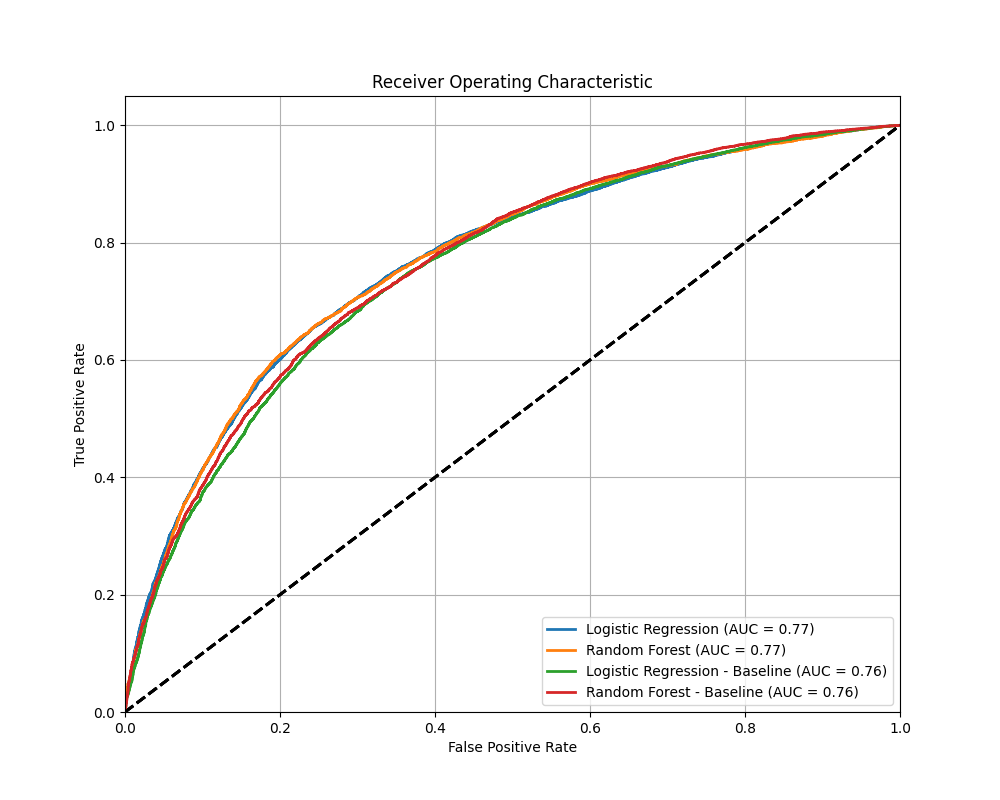

In [61]:
%matplot plt

### 7. Do Your Best

In all previous sections in this assignment and other assignments so far, we have almost specified everything you should do. You might be (and should be!) bored by now. This section gives you a chance to do whatever you want to improve the prediction AUC. 

You can do better data preprocessing, feature engineering, fit fancier models, perform hyperparameter tuning, etc. 

After you are satisfied with your model, ✰2.8 in your writeup, report 
- the hyperparameters,
- train and test AUC of your optimized model, and 
- the approach you took on top of the specified instructions to obtain this better result.

In [64]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize Random Forest Model
rf = RandomForestClassifier(featuresCol="final_scaled_features", labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction")

# Set Up the Parameter Grid for Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Set Up Evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

# Set Up Cross Validator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Fit the Model
cvModel = cv.fit(train_data)

# Evaluate the Model
train_auc = evaluator.evaluate(cvModel.transform(train_data))
test_auc = evaluator.evaluate(cvModel.transform(test_data))

# Print the Performance Metrics
print(f"Random Forest - Train AUC: {train_auc}")
print(f"Random Forest - Test AUC: {test_auc}")

# Get the Best Model and Parameters (Optional)
best_model = cvModel.bestModel
best_params = best_model.extractParamMap()
for param, value in best_params.items():
    print(f"{param.name}: {value}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest - Train AUC: 0.9994036370497007
Random Forest - Test AUC: 0.8620067672340108
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: final_scaled_features
impurity: gini
labelCol: label
leafCol: 
maxBins: 32
maxDepth: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 30
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -5387697053847413545
subsamplingRate: 1.0

### 8. Don't forget to answer the reflection question on the writeup! ✰2.9